# Smart Cricket Score Predictor (DS)
- Smart Cricket Score Display and Match Insights System
- Beginner-friendly Data Science Project
- Author: Yogesh Londhe
- Description:
-   Uses IPL ball-by-ball data to display match insights and predict final scores
-   based on the first 10 overs of an innings.

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# STEP 1: Load the dataset
# -----------------------------

In [10]:
DATA_PATH = "deliveries_updated_mens_ipl_upto_2024.csv"

if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"Dataset not found! Please place it at: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df = df.rename(columns={"matchId": "match_id"})
df["total_runs"] = df["batsman_runs"] + df["extras"]

# Mark wickets
df["is_wicket"] = (~df["player_dismissed"].isna()) & (df["player_dismissed"].astype(str).str.strip() != "")

df["over"] = pd.to_numeric(df["over"], errors="coerce").astype(int)
df["ball"] = pd.to_numeric(df["ball"], errors="coerce").astype(int)

# -----------------------------
# STEP 2: Compute cumulative stats
# -----------------------------

In [11]:
df = df.sort_values(["match_id", "inning", "over", "ball"]).copy()
df["cumulative_runs"] = df.groupby(["match_id", "inning"])["total_runs"].cumsum()
df["cumulative_wickets"] = df.groupby(["match_id", "inning"])["is_wicket"].cumsum()

# Final total per innings
innings_totals = (
    df.groupby(["match_id", "inning"], as_index=False)["total_runs"]
    .sum()
    .rename(columns={"total_runs": "final_total"})
)

# -----------------------------
# STEP 3: Extract state at 10 overs
# -----------------------------

In [12]:
state_10 = (
    df[df["over"] <= 10]
    .groupby(["match_id", "inning"])
    .tail(1)[["match_id", "inning", "cumulative_runs", "cumulative_wickets"]]
    .rename(columns={"cumulative_runs": "runs_10", "cumulative_wickets": "wickets_10"})
)

# Add last-5-over and powerplay runs
runs_6_10 = (
    df[(df["over"] >= 6) & (df["over"] <= 10)]
    .groupby(["match_id", "inning"])["total_runs"]
    .sum()
    .reset_index()
    .rename(columns={"total_runs": "runs_6_10"})
)
pp_runs = (
    df[(df["over"] >= 1) & (df["over"] <= 6)]
    .groupby(["match_id", "inning"])["total_runs"]
    .sum()
    .reset_index()
    .rename(columns={"total_runs": "pp_runs"})
)

# Merge features
features = (
    state_10.merge(runs_6_10, on=["match_id", "inning"], how="left")
    .merge(pp_runs, on=["match_id", "inning"], how="left")
    .merge(innings_totals, on=["match_id", "inning"], how="left")
)
features["runs_6_10"] = features["runs_6_10"].fillna(0)
features["pp_runs"] = features["pp_runs"].fillna(0)
features["run_rate_10"] = features["runs_10"] / 10.0

# -----------------------------
# STEP 4: Build predictive model
# -----------------------------

In [13]:
model_df = features[
    ["runs_10", "wickets_10", "runs_6_10", "pp_runs", "run_rate_10", "final_total"]
].dropna()

X = model_df[["runs_10", "wickets_10", "runs_6_10", "pp_runs", "run_rate_10"]].values
y = model_df["final_total"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 💡 Using Linear Regression instead of RandomForest
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f} runs")
print(f"R² Score: {r2:.3f}")
print(f"Total Innings Used: {model_df.shape[0]}")

# 🔍 Display sample predictions
print("\n📈 Sample Predictions (Actual vs Predicted Final Totals):")
for i in range(5):
    print(f"Actual: {y_test[i]:.0f}, Predicted: {y_pred[i]:.0f}")


✅ Model Performance:
Mean Absolute Error (MAE): 19.30 runs
R² Score: 0.562
Total Innings Used: 2217

📈 Sample Predictions (Actual vs Predicted Final Totals):
Actual: 131, Predicted: 137
Actual: 101, Predicted: 116
Actual: 180, Predicted: 153
Actual: 129, Predicted: 115
Actual: 126, Predicted: 143


# -----------------------------
# STEP 5: Feature importance (using coefficients)
# -----------------------------

In [14]:
features_imp = pd.DataFrame(
    {"Feature": ["runs_10", "wickets_10", "runs_6_10", "pp_runs", "run_rate_10"],
     "Coefficient": model.coef_}
).sort_values("Coefficient", ascending=False)

print("\n📊 Feature Importance (Coefficients):")
print(features_imp.to_string(index=False))


📊 Feature Importance (Coefficients):
    Feature  Coefficient
    runs_10     0.867725
  runs_6_10     0.723727
    pp_runs     0.158912
run_rate_10     0.086772
 wickets_10    -1.385503


# -----------------------------
# STEP 6: Visualizations
# -----------------------------

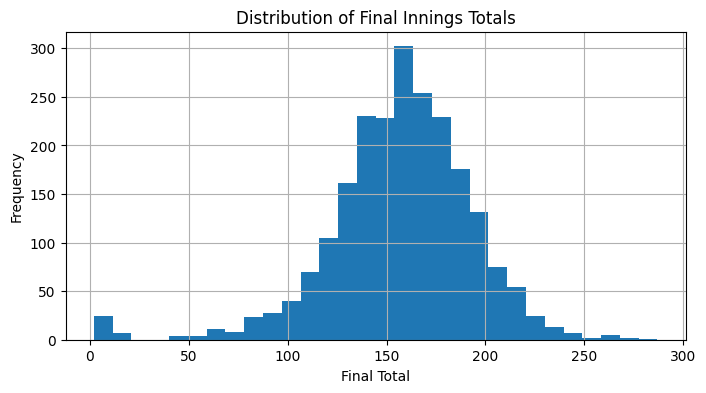

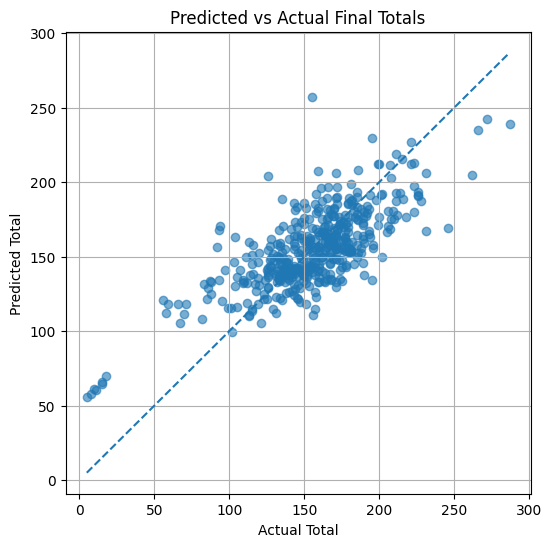

In [15]:
plt.figure(figsize=(8, 4))
plt.hist(model_df["final_total"], bins=30)
plt.title("Distribution of Final Innings Totals")
plt.xlabel("Final Total")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--')
plt.xlabel("Actual Total")
plt.ylabel("Predicted Total")
plt.title("Predicted vs Actual Final Totals")
plt.grid(True)
plt.show()

# -----------------------------
# STEP 7: Sample Match Progress
# -----------------------------

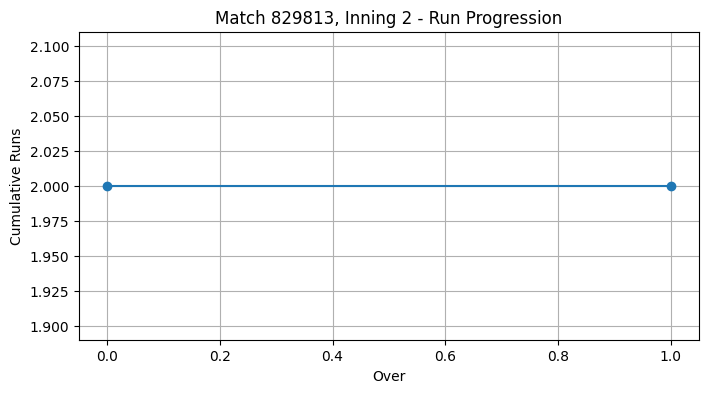

In [16]:
sample = features.sample(1, random_state=10).iloc[0]
mid, inning = int(sample["match_id"]), int(sample["inning"])
match_df = df[(df["match_id"] == mid) & (df["inning"] == inning)]

over_cum = match_df.groupby("over", as_index=False)["total_runs"].sum().cumsum()
plt.figure(figsize=(8, 4))
plt.plot(over_cum["over"], over_cum["total_runs"], marker='o')
plt.title(f"Match {mid}, Inning {inning} - Run Progression")
plt.xlabel("Over")
plt.ylabel("Cumulative Runs")
plt.grid(True)
plt.show()

# -----------------------------
# STEP 8: Top 10 Batsmen
# -----------------------------


🏏 Top 10 Batsmen by Total Runs:
       batsman  batsman_runs
       V Kohli          8014
      S Dhawan          6769
     RG Sharma          6630
     DA Warner          6567
      SK Raina          5536
      MS Dhoni          5243
AB de Villiers          5181
      CH Gayle          4997
    RV Uthappa          4954
    KD Karthik          4843


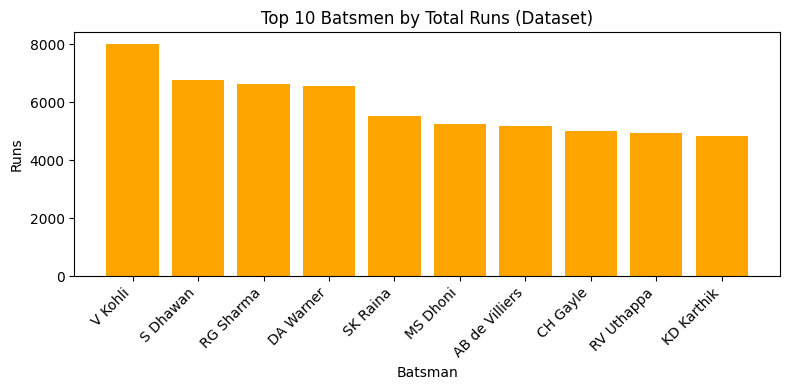

In [17]:
top_batsmen = (
    df.groupby("batsman", as_index=False)["batsman_runs"]
    .sum()
    .sort_values("batsman_runs", ascending=False)
    .head(10)
)
print("\n🏏 Top 10 Batsmen by Total Runs:")
print(top_batsmen.to_string(index=False))

plt.figure(figsize=(8, 4))
plt.bar(top_batsmen["batsman"], top_batsmen["batsman_runs"], color="orange")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Batsmen by Total Runs (Dataset)")
plt.xlabel("Batsman")
plt.ylabel("Runs")
plt.tight_layout()
plt.show()